This plot is for Fig 1C, the N terminal amino acid analysis. ALSO, this notebook makes the accompanying figure of raw codon frequencies.

In [1]:
# import statements
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from collections import Counter
import scipy.stats as sp

import matplotlib
import matplotlib.font_manager as fm
import os
fpath = '/Library/Fonts/Myriad-Pro_31655.ttf'
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]
axis_font = {'fontname':fname, 'fontproperties':prop}

# Part 1: Load in and clean up data for use

In [2]:
# load in data
data_dir = '../../data/'
file_name = 'newQC_toehold_data.csv'
data_df = pd.read_csv(data_dir + file_name,sep=',')
print(data_df.head(5))

                                              off_id  \
0  AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...   
1  AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...   
2  AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...   
3  AACCAAACACACAAACGCACAAAAAAAATAACGTAGGACTACTACT...   
4  AACCAAACACACAAACGCACAAAAAAAATGGAAAACAGTTACTAAT...   

                                               on_id source_sequence  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
2  CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...        smallpox   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTTAACCAAACACACAAAC...        smallpox   
4  ACATATTAGTAACTGTTTTCCATTTTTTTTAACCAAACACACAAAC...        smallpox   

          sequence_id               pre_seq              promoter  \
0  smallpox_tile_2626  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
1  smallpox_tile_2625  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
2  smallpox_tile_4951  

### Filter the data based on QCs, as defined in Angenent-Mari et al.

In [3]:
new_data_df = data_df[~np.isnan(data_df['on_value'])]
new_data_df = new_data_df[~np.isnan(new_data_df['off_value'])]
new_data_df = new_data_df[new_data_df['off_qc'] >= 1.1]
new_data_df = new_data_df[new_data_df['on_qc'] >= 1.1].reset_index()

toehold_seqs = new_data_df['switch_sequence']
seq_len = len(toehold_seqs[0])

print('Number of remaining sequences: ', len(new_data_df))

Number of remaining sequences:  91534


In [4]:
# Extract top performing sequences from the experimental data
sorted_exp = new_data_df.sort_values(by = 'onoff_value')
cutoff = np.percentile(sorted_exp['onoff_value'], 95) # return 95th percentile and above
print(cutoff)
sorted_exp = new_data_df[new_data_df['onoff_value'] > cutoff]
print(sorted_exp.shape)

0.7677348822499992
(4577, 23)


In [5]:
# Extract bottom performing sequences from the experimental data
bottom_sorted_exp = new_data_df.sort_values(by = 'onoff_value')
cutoff = np.percentile(bottom_sorted_exp['onoff_value'], 5) # return 5th percentile and below
print(cutoff)
bottom_sorted_exp = new_data_df[new_data_df['onoff_value'] < cutoff]
print(bottom_sorted_exp.shape)

-0.09593931734999996
(4577, 23)


# Part 2: Get all, top, and bottom sequences and convert to RNA

In [6]:
all_seqs = new_data_df.loc[:,'switch_sequence']
subset_seqs = sorted_exp.loc[:, 'switch_sequence']
bot_subset_seqs = bottom_sorted_exp.loc[:, 'switch_sequence']

In [7]:
# convert all seqs to RNA instead of DNA
def convert_DNA_to_RNA(one_seq):
    new_str = ''
    for s in one_seq:
        char = ''
        if s == 'A':
            char = 'A'
        elif s == 'T':
            char = 'U'
        elif s == 'C':
            char = 'C'
        elif s == 'G':
            char = 'G'
        else:
            print('UH OH! Character not A, T, C, or G')
        new_str += char
    return new_str

## In addition, break up from 50-59 into its 3 respective non-overlapping codons

In [8]:
# break up the codon composition for n terminus
def break_into_codons(one_seq):
    location_of_start = 50
    length = len(one_seq)
    if (length < location_of_start):
        print("Bad length")
    
    codon_list = []
    for nt in range(location_of_start, length, 3):
        curr_codon = one_seq[location_of_start + (len(codon_list) * 3):location_of_start + (len(codon_list) * 3) + 3]
        codon_list.append(curr_codon)
    return codon_list

In [9]:
all_seqs = [convert_DNA_to_RNA(x) for x in all_seqs]
subset_seqs = [convert_DNA_to_RNA(x) for x in subset_seqs]
bot_subset_seqs = [convert_DNA_to_RNA(x) for x in bot_subset_seqs]

codon_comp = [break_into_codons(x) for x in all_seqs]
sub_codon_comp = [break_into_codons(x) for x in subset_seqs]
bot_sub_codon_comp = [break_into_codons(x) for x in bot_subset_seqs]

# Part 3: Get the frequencies of the codons at these three positions

In [10]:
amino_acid_dict = {
    'UUU': 'Phe', 'UUC': 'Phe', 'UUA': 'Leu', 'UUG': 'Leu',
    'CUU': 'Leu', 'CUC': 'Leu', 'CUA': 'Leu', 'CUG': 'Leu',
    'AUU': 'Ile', 'AUC': 'Ile', 'AUA': 'Ile', 'AUG': 'Met',
    'GUU': 'Val', 'GUC': 'Val', 'GUA': 'Val', 'GUG': 'Val',
    'UCU': 'Ser', 'UCC': 'Ser', 'UCA': 'Ser', 'UCG': 'Ser',
    'CCU': 'Pro', 'CCC': 'Pro', 'CCA': 'Pro', 'CCG': 'Pro',
    'ACU': 'Thr', 'ACC': 'Thr', 'ACA': 'Thr', 'ACG': 'Thr',
    'GCU': 'Ala', 'GCC': 'Ala', 'GCA': 'Ala', 'GCG': 'Ala',
    'UAU': 'Tyr', 'UAC': 'Tyr', 'UAA': ' Stop', 'UAG': ' Stop',
    'CAU': 'His', 'CAC': 'His', 'CAA': 'Gln', 'CAG': 'Gln',
    'AAU': 'Asn', 'AAC': 'Asn', 'AAA': 'Lys', 'AAG': 'Lys',
    'GAU': 'Asp', 'GAC': 'Asp', 'GAA': 'Glu', 'GAG': 'Glu',
    'UGU': 'Cys', 'UGC': 'Cys', 'UGA': ' Stop', 'UGG': 'Trp',
    'CGU': 'Arg', 'CGC': 'Arg', 'CGA': 'Arg', 'CGG': 'Arg',
    'AGU': 'Ser', 'AGC': 'Ser', 'AGA': 'Arg', 'AGG': 'Arg',
    'GGU': 'Gly', 'GGC': 'Gly', 'GGA': 'Gly', 'GGG': 'Gly'
}

In [11]:
def summarize_aa_lists(codon_list):
    aa_dict = {}
    for seq in codon_list:
        for codon in seq:
            aa = amino_acid_dict[codon]
            if aa in aa_dict:
                aa_num = aa_dict[aa]
                aa_dict[aa] = aa_num + 1
            else:
                aa_dict[aa] = 1
    return aa_dict

In [12]:
# Make dictionaries mapping the codons to their frequencies
codon_dict = summarize_aa_lists(codon_comp)
factor=1.0/sum(codon_dict.values())
codon_dict = {k: v*factor for k, v in codon_dict.items() }
codon_dict = dict(sorted(codon_dict.items()))
#print(codon_dict)

sub_codon_dict = summarize_aa_lists(sub_codon_comp)
factor=1.0/sum(sub_codon_dict.values())
sub_codon_dict = {k: v*factor for k, v in sub_codon_dict.items() }
sub_codon_dict = dict(sorted(sub_codon_dict.items()))
#print(sub_codon_dict)

bot_sub_codon_dict = summarize_aa_lists(bot_sub_codon_comp)
factor=1.0/sum(bot_sub_codon_dict.values())
bot_sub_codon_dict = {k: v*factor for k, v in bot_sub_codon_dict.items() }
bot_sub_codon_dict = dict(sorted(bot_sub_codon_dict.items()))
#print(bot_sub_codon_dict)

In [13]:
# custom sort to order x ticks
from collections import OrderedDict

def customsort(dict1 , key_order):
    items = [dict1[k] if k in dict1.keys() else 0 for k in key_order] 
    sorted_dict = OrderedDict()
    for i in range(len(key_order)):
        sorted_dict[key_order[i]] = items[i]
    return sorted_dict

#key_order = [" Stop","Ala","Val","Gly","Trp","Met","Ile","Leu","Phe","Pro","Ser","Thr","Cys","Tyr","Asn","Gln","His","Lys","Arg","Asp","Glu"]
key_order = [" Stop","Pro","Phe","Leu","Ile","Ala","Trp","Gly","Val","Met","Tyr","Ser","Asn","Cys","Gln","Thr","His","Lys","Arg","Asp","Glu"]

sorted_dict_all = customsort(codon_dict,key_order)
sorted_dict_top = customsort(sub_codon_dict,key_order)
sorted_dict_bot = customsort(bot_sub_codon_dict,key_order)

# Part 4: Make supp fig of raw codon frequencies

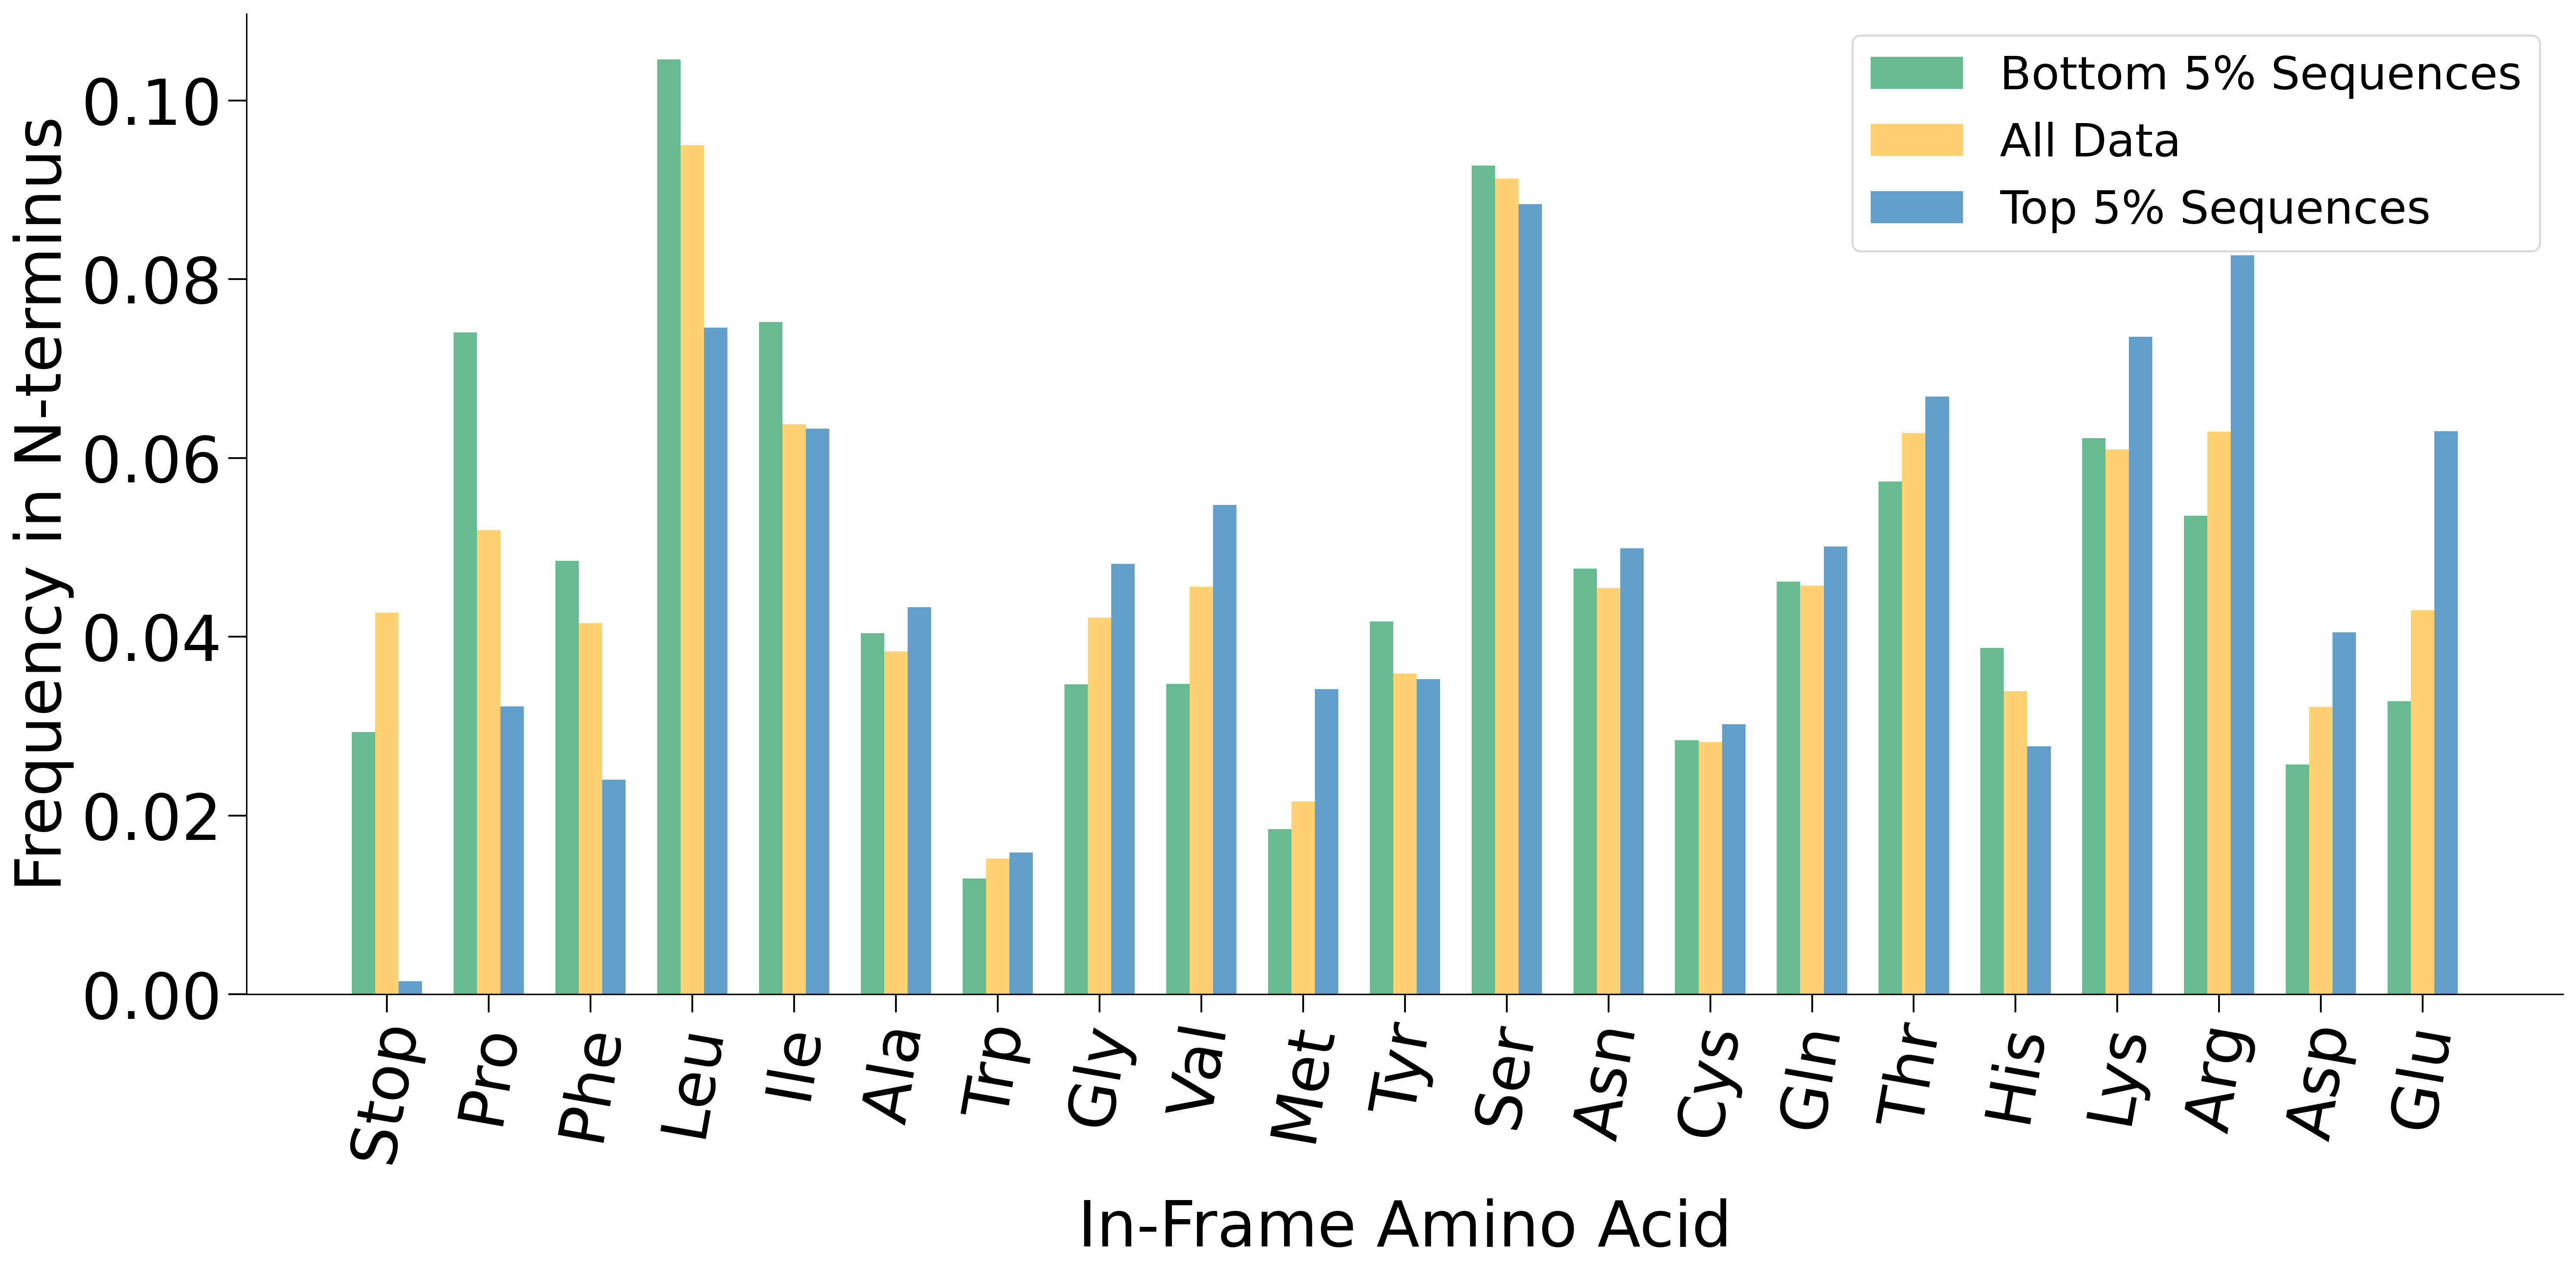

In [14]:
# SUPP FIG
fig, ax = plt.subplots(figsize = (23, 10), dpi = 300)
ax.patch.set_facecolor('white')

barWidth = 0.23
r1 = range(len(sorted_dict_all))
r0 = [x - barWidth for x in r1]
r2 = [x + barWidth for x in r1]
r3 = [x + 0.1 for x in r1]

plt.bar(r0, list(sorted_dict_bot.values()), color = '#259F62', align='center', alpha=0.7, label='Bottom 5% Sequences', width = barWidth);
plt.bar(r1, list(sorted_dict_all.values()), color = '#FFBE33', align='center', alpha=0.7, label='All Data', width = barWidth);
plt.bar(r2, list(sorted_dict_top.values()), color = 'tab:blue', align='center', alpha =0.7, label='Top 5% Sequences', width = barWidth);
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.set_xticks(r3)
ax.tick_params(length = 10, width = 1)
plt.xticks(r1, list(sorted_dict_all.keys()), rotation='80', fontsize = 35);
plt.yticks(fontsize = 35)
plt.xlabel('In-Frame Amino Acid', fontsize = 35)
plt.ylabel('Frequency in N-terminus', fontsize = 35)
plt.legend(loc='best', fontsize = 25.5, facecolor = 'white', fancybox = True, shadow = False)

output_dir = '../../illustrator_files/supp/'
#plt.savefig(output_dir + 'figs2_nterm_aa.svg', format='svg')
plt.show()

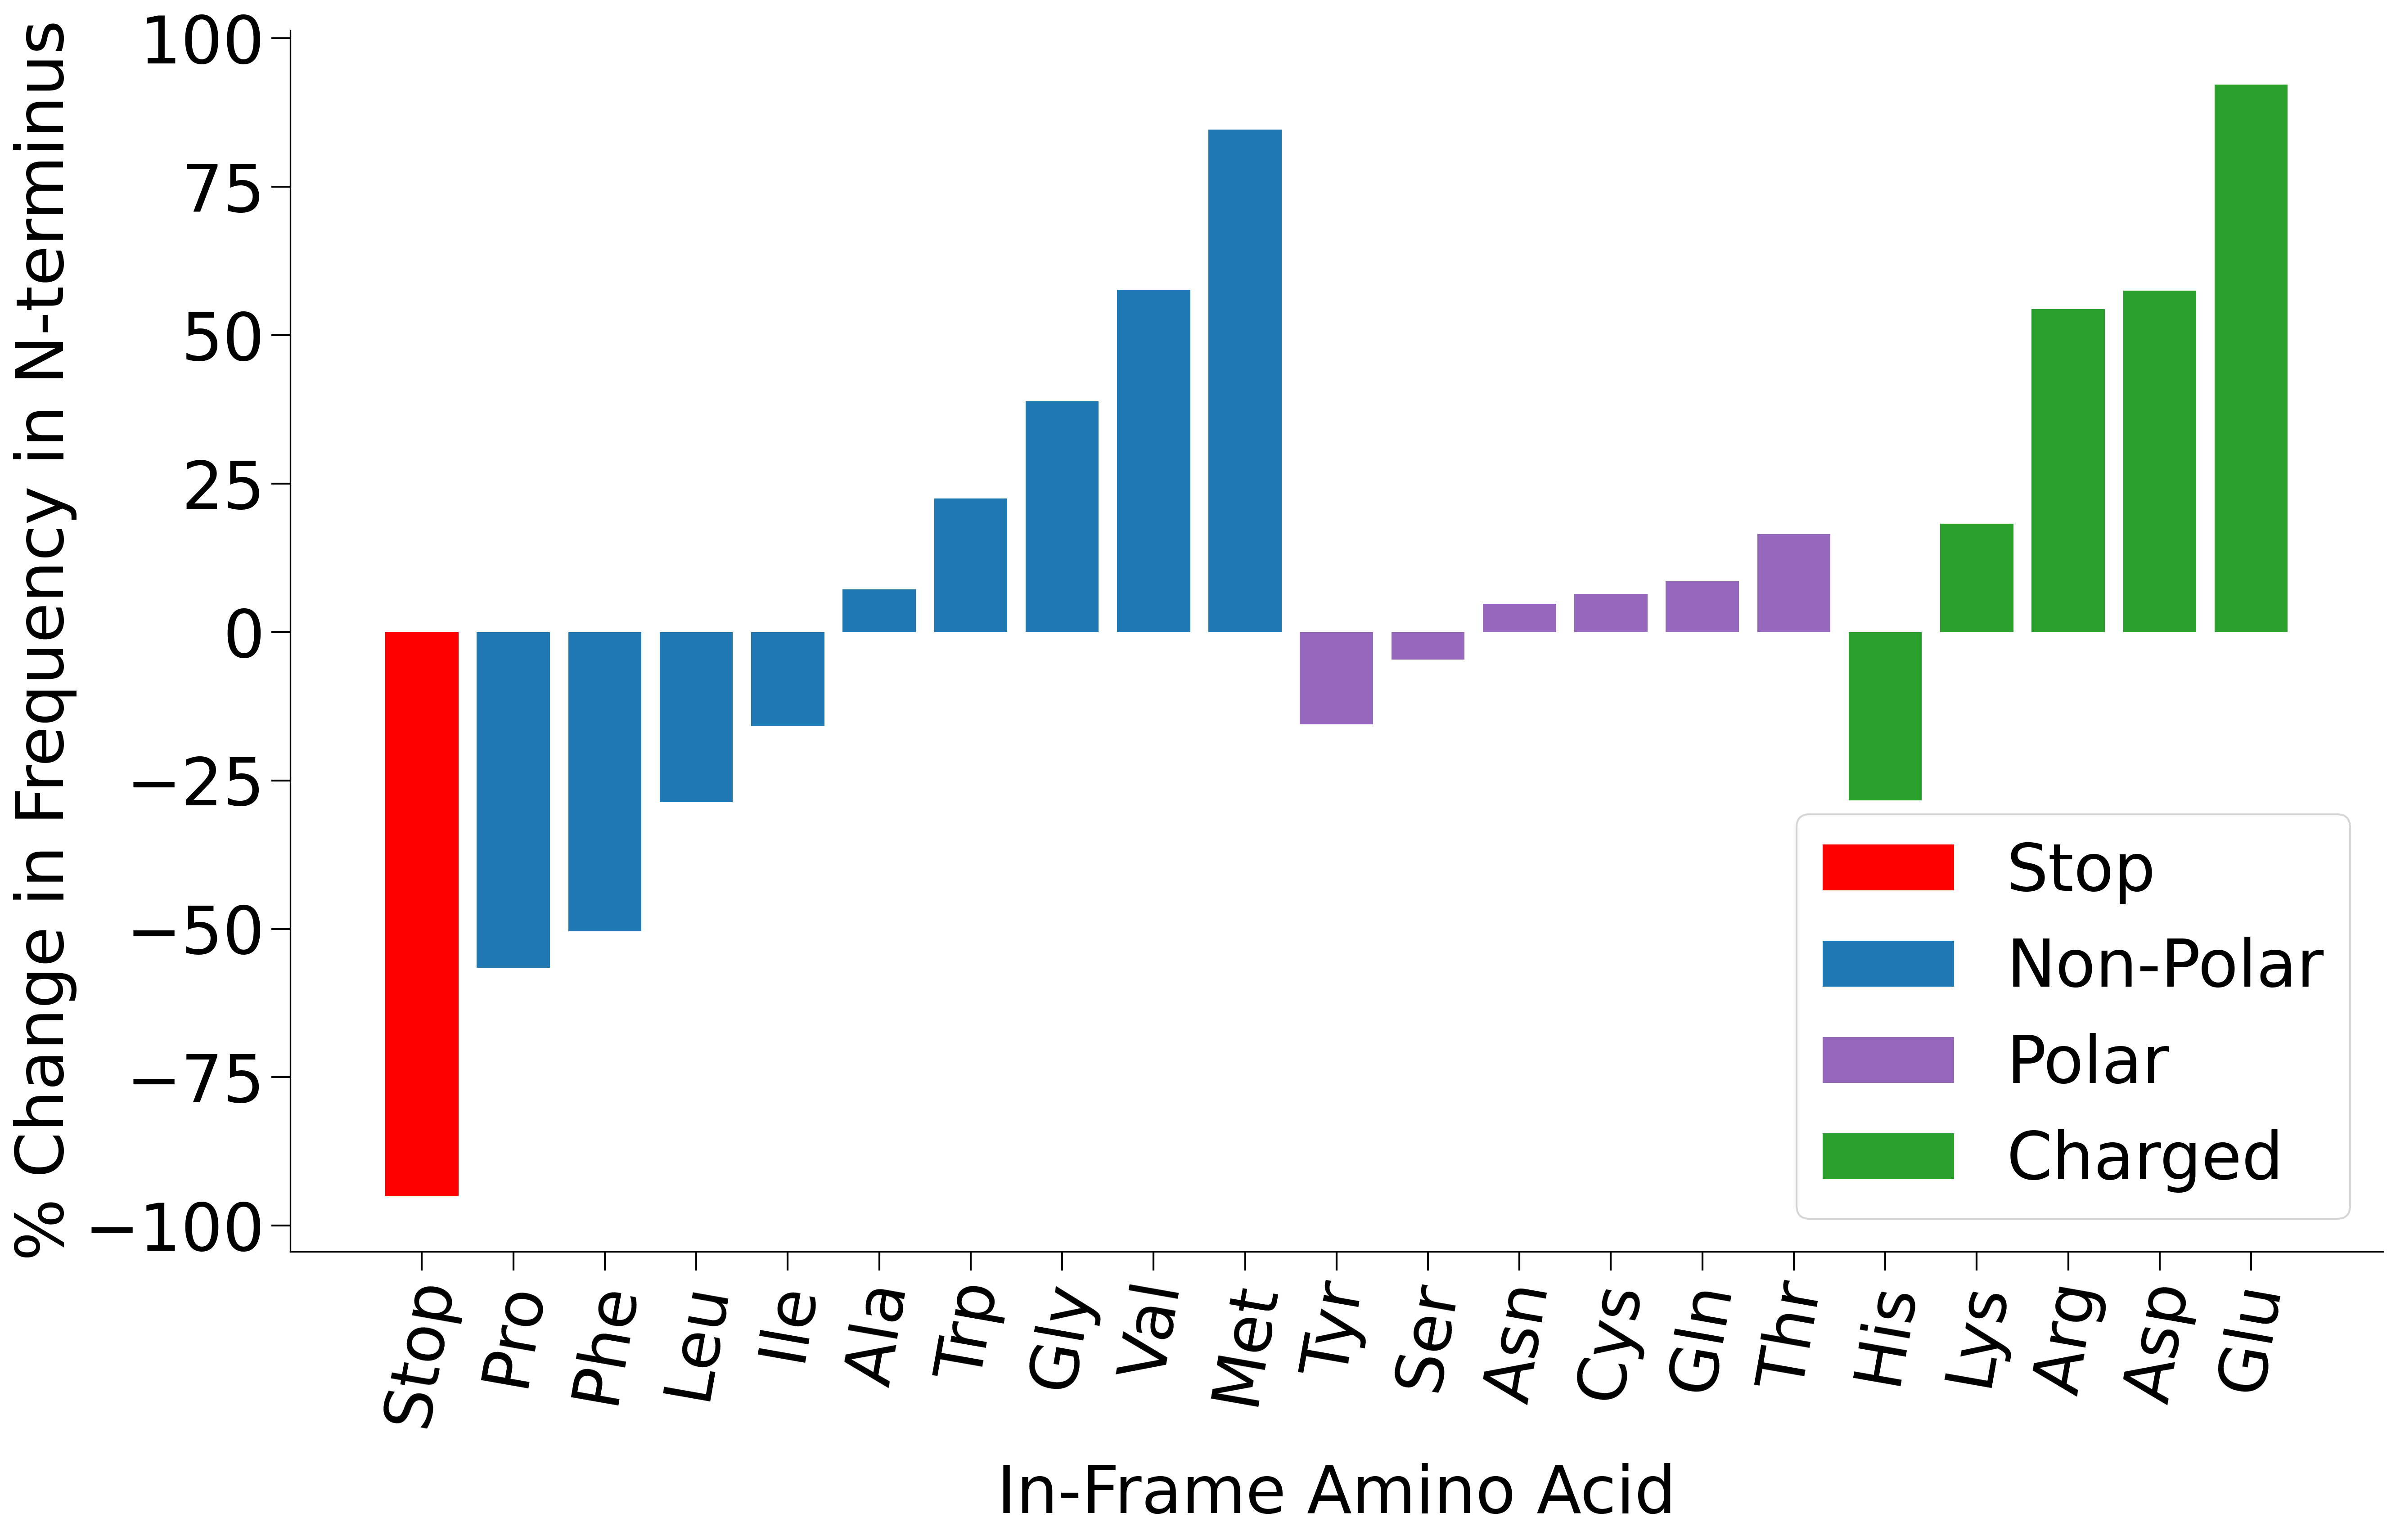

In [15]:
fig, ax = plt.subplots(figsize = (20, 12), dpi = 300)
ax.patch.set_facecolor('white')

def get_percent_change(a_i, b_i):
    result = ((a_i - b_i) / b_i) * 100
    return result

delta_freq = [get_percent_change(a_i, b_i) for a_i, b_i in zip(list(sorted_dict_top.values()),list(sorted_dict_bot.values()))]

r1 = range(len(sorted_dict_all))

color_stop = ['red']
color_hydrophobic = ['tab:blue'] * 9
color_polar = ['tab:purple'] * 6
color_charged = ['tab:green'] * 5

color_stop.extend(color_hydrophobic)
color_stop.extend(color_polar)
color_stop.extend(color_charged)

plt.bar(r1[0], delta_freq[0], color = color_stop[0])
plt.bar(r1[1:10], delta_freq[1:10], color = color_stop[1:10])
plt.bar(r1[10:16], delta_freq[10:16], color = color_stop[10:16])
plt.bar(r1[16:21], delta_freq[16:21], color = color_stop[16:21])

plt.legend(('Stop', 'Non-Polar', 'Polar', 'Charged'), fontsize = 35, loc = 'lower right')

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.set_xticks(r3)
ax.tick_params(length = 10, width = 1)
plt.xticks(r1, list(sorted_dict_all.keys()), rotation='80', fontsize = 35);
plt.yticks(fontsize = 35)
plt.xlabel('In-Frame Amino Acid', fontsize = 35)
plt.ylabel('% Change in Frequency in N-terminus', fontsize = 35)

#plt.savefig(output_dir + 'nterm_aa_exploration.svg', format='svg')
plt.show()